In [1]:
from sys import version
print(version)


3.8.2 (default, Mar 11 2020, 00:28:52) 
[Clang 11.0.0 (clang-1100.0.33.17)]


In [14]:
from app import AppContext, Word as WordModel
from core import LoadConfig
import numpy as np

from scipy.interpolate import griddata

from typing import *
from time import time


In [236]:
ctx = AppContext(LoadConfig("configs/main.yaml"))


class Word:
    def __init__(self, word: str,
                 t: np.ndarray = None, 
                 v: np.ndarray = None):
        self.word = word.strip().lower()
        self.t = t
        self.v = v
        if t is not None and v is not None:
            assert len(t) == len(v), (len(t), len(v))
            
    def _set_default_v(self):
        assert self.v is None
        self.t, self.v = np.unique(self.t, return_counts=True)
    
    async def download(self, period_s=60 * 60 * 24 * 30 * 6):
        word_p = []
        start_time = time() - period_s
        async for word in ctx.db.find(WordModel(word=self.word)):
            if word.date >= start_time:
                word_p.append(word.date)
        word_ts = np.array(word_p)
        self.t = word_ts
        self.t.sort()
    
    def slice(self, from_p=5, to_p=95):
        from_p_val = np.percentile(self.t, from_p)
        to_p_val = np.percentile(self.t, to_p)
        
        filter_ = (from_p_val < self.t) & (self.t < to_p_val)
        
        return Word(self.word, self.t[filter_], self.v[filter_] if self.v is not None else None) 
    
    def integrate(self):
        if self.v is None:
            self._set_default_v()
        return Word(self.word, self.t, np.cumsum(self.v))
    
    def diff(self):
        return Word(self.word,
                    self.t,
                    np.diff(self.v)
                    )
    
    def moving_avg(self, periods):
        periods = int(periods)
        weights = np.ones(periods) / periods
        v = np.convolve(self.v, weights, mode='same')
        return Word(self.word, self.t, v)
    
    def to_grid(self, coef):
        if self.v is None:
            self._set_default_v()
            
        period = np.percentile(np.diff(self.t), 50) / coef
        print(period)
        count = int((self.t.max() - self.t.min()) // period or 0) + 1
        start_ = self.t.min()

        xi = np.linspace(self.t.min(), self.t.max(), num=count, dtype=int)
        assert self.t.max() == xi.max(), (self.t.max(), xi.max())
        v = np.zeros((count + 1, ), dtype=int)
        
        indexes = ((self.t - start_) // period).round().astype(int)
        print(indexes, self.v)
        
        np.add.at(v, indexes, self.v)
        print(xi)
        print(v)
        print(v.sum(), self.v.sum())
        
        return Word(self.word, xi, v[:-1])
        
    def get_smooth(self, coef=1, mov=True):
        result = self.slice().integrate().to_grid(coef)#.diff()
        if mov:
            result = result.moving_avg(coef * 2)
        return result
    

[2020-04-11 22:00:04.566096] [  INFO   ] /42169/ LoadConfig core/config/__init__.py:13 LoadConfig: Load config source=configs/main.yaml


In [242]:
from plotly import graph_objects as go


def draw_word(fig, word_ts: Word,
              name, opacity=None, mode=None):
    y = word_ts.v
    assert y is not None

    from datetime import datetime
    x_dt = [datetime.fromtimestamp(ts) for ts in word.t]

    fig.add_trace(go.Scatter(x=x_dt, y=y,
                             name=name, opacity=opacity,
                             mode=mode))

word = Word("нгу")
await word.download()

word = Word("test", np.array(
    [time() - 60 * 60, time(), time() + 60 * 60, time() + 60 * 60, time() + 60 * 60 * 3, time() + 60 * 60 * 3, time() + 60 * 60 * 4],
    dtype=int
))
print(word.t)

print(word.slice().t)

[1586613685 1586617285 1586620885 1586620885 1586628085 1586628085
 1586631685]
[1586617285 1586620885 1586620885 1586628085 1586628085]


In [243]:
fig = go.Figure()

for i in range(1, 10):
    draw_word(fig, word.slice().to_grid(i/2).integrate(), name=f"grid_{i/2}")

draw_word(fig, word.slice().integrate(), name="slice+int")

# for mov in (False,):
#     for i in range(1, 5):
#         draw_word(fig, word.get_smooth(i, mov=mov), name=f'smooth_{i}_{mov}')

fig.show()



10800.0
[0 0 1] [1 2 2]
[1586617285 1586628085]
[3 2 0]
5 5
5400.0
[0 0 2] [1 2 2]
[1586617285 1586622685 1586628085]
[3 0 2 0]
5 5
3600.0
[0 1 3] [1 2 2]
[1586617285 1586620885 1586624485 1586628085]
[1 2 0 2 0]
5 5
2700.0
[0 1 4] [1 2 2]
[1586617285 1586619985 1586622685 1586625385 1586628085]
[1 2 0 0 2 0]
5 5
2160.0
[0 1 5] [1 2 2]
[1586617285 1586619445 1586621605 1586623765 1586625925 1586628085]
[1 2 0 0 0 2 0]
5 5
1800.0
[0 2 6] [1 2 2]
[1586617285 1586619085 1586620885 1586622685 1586624485 1586626285
 1586628085]
[1 0 2 0 0 0 2 0]
5 5
1542.857142857143
[0 2 6] [1 2 2]
[1586617285 1586619085 1586620885 1586622685 1586624485 1586626285
 1586628085]
[1 0 2 0 0 0 2 0]
5 5
1350.0
[0 2 8] [1 2 2]
[1586617285 1586618635 1586619985 1586621335 1586622685 1586624035
 1586625385 1586626735 1586628085]
[1 0 2 0 0 0 0 0 2 0]
5 5
1200.0
[0 3 9] [1 2 2]
[1586617285 1586618485 1586619685 1586620885 1586622085 1586623285
 1586624485 1586625685 1586626885 1586628085]
[1 0 0 2 0 0 0 0 0 2 0]
5 

In [244]:
word.slice().t

array([1586617285, 1586620885, 1586620885, 1586628085, 1586628085])

10800.0
[0 0 1] [1 2 2]
[1586617285 1586628085]
[3 2 0]
5 5
5400.0
[0 0 2] [1 2 2]
[1586617285 1586622685 1586628085]
[3 0 2 0]
5 5
3600.0
[0 1 3] [1 2 2]
[1586617285 1586620885 1586624485 1586628085]
[1 2 0 2 0]
5 5
2700.0
[0 1 4] [1 2 2]
[1586617285 1586619985 1586622685 1586625385 1586628085]
[1 2 0 0 2 0]
5 5
2160.0
[0 1 5] [1 2 2]
[1586617285 1586619445 1586621605 1586623765 1586625925 1586628085]
[1 2 0 0 0 2 0]
5 5
1800.0
[0 2 6] [1 2 2]
[1586617285 1586619085 1586620885 1586622685 1586624485 1586626285
 1586628085]
[1 0 2 0 0 0 2 0]
5 5
1542.857142857143
[0 2 6] [1 2 2]
[1586617285 1586619085 1586620885 1586622685 1586624485 1586626285
 1586628085]
[1 0 2 0 0 0 2 0]
5 5
1350.0
[0 2 8] [1 2 2]
[1586617285 1586618635 1586619985 1586621335 1586622685 1586624035
 1586625385 1586626735 1586628085]
[1 0 2 0 0 0 0 0 2 0]
5 5
1200.0
[0 3 9] [1 2 2]
[1586617285 1586618485 1586619685 1586620885 1586622085 1586623285
 1586624485 1586625685 1586626885 1586628085]
[1 0 0 2 0 0 0 0 0 2 0]
5 

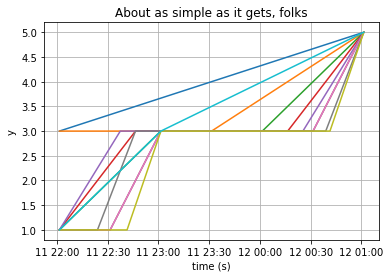

In [249]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
from datetime import datetime

fig, ax = plt.subplots()
    
def plot(ax, word, name):
    t = [datetime.fromtimestamp(ts) for ts in word.t]
    s = word.v
    
    ax.plot(t, s, label=[name])
    
ax.set(xlabel='time (s)', ylabel='y',
       title='About as simple as it gets, folks')
ax.grid()


for i in range(1, 10):
    plot(ax, word.slice().to_grid(i/2).integrate(), name=f"grid_{i/2}")

plot(ax, word.slice().integrate(), name="slice+int")


fig.savefig("test.png")
plt.show()